## Imports

In [1]:
!pip install datasets
!pip install python-chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.3 MB/s eta 0:00:00


In [2]:
import torch

import chess
import chess.engine
import chess.svg

from transformers import AutoTokenizer, TextGenerationPipeline, \
    GPT2LMHeadModel, GPT2Tokenizer, pipeline

from datasets import load_from_disk, load_dataset

from copy import deepcopy
from typing import List, Dict, Optional, Any

from utils.chessplaying_utils import *

import warnings
warnings.filterwarnings("ignore")

In [4]:
!wget https://github.com/official-stockfish/Stockfish/releases/latest/download/stockfish-ubuntu-x86-64-avx2.tar  # type: ignore

--2024-05-25 13:37:48--  https://github.com/official-stockfish/Stockfish/releases/latest/download/stockfish-ubuntu-x86-64-avx2.tar
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/official-stockfish/Stockfish/releases/download/sf_16.1/stockfish-ubuntu-x86-64-avx2.tar [following]
--2024-05-25 13:37:49--  https://github.com/official-stockfish/Stockfish/releases/download/sf_16.1/stockfish-ubuntu-x86-64-avx2.tar
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/20976138/2c8919f2-0a02-4f38-ab23-d1919a99521d?X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Credential=releaseassetproduction%2F20240525%2Fus-east-1%2Fs3%2Faws4_request&X-Amz-Date=20240525T133749Z&X-Amz-Expires=300&X-Amz-Signature=1bd3846e8d372bd8b97c72a1051066

In [5]:
!mkdir /sf
!tar -C /sf -xvf stockfish-ubuntu-x86-64-avx2.tar

stockfish/
stockfish/Copying.txt
stockfish/CONTRIBUTING.md
stockfish/wiki/
stockfish/wiki/Home.md
stockfish/wiki/Useful-data.md
stockfish/wiki/Governance-and-responsibilities.md
stockfish/wiki/Stockfish-FAQ.md
stockfish/wiki/Regression-Tests.md
stockfish/wiki/Terminology.md
stockfish/wiki/_Footer.md
stockfish/wiki/UCI-&-Commands.md
stockfish/wiki/Advanced-topics.md
stockfish/wiki/Developers.md
stockfish/wiki/Compiling-from-source.md
stockfish/wiki/Download-and-usage.md
stockfish/README.md
stockfish/src/
stockfish/src/benchmark.cpp
stockfish/src/syzygy/
stockfish/src/syzygy/tbprobe.cpp
stockfish/src/syzygy/tbprobe.h
stockfish/src/uci.cpp
stockfish/src/tt.h
stockfish/src/timeman.cpp
stockfish/src/benchmark.h
stockfish/src/position.cpp
stockfish/src/types.h
stockfish/src/evaluate.cpp
stockfish/src/perft.h
stockfish/src/search.h
stockfish/src/tt.cpp
stockfish/src/movegen.h
stockfish/src/movepick.h
stockfish/src/thread.h
stockfish/src/Makefile
stockfish/src/ucioption.h
stockfish/src/uciopti

In [6]:
!cd /sf/stockfish && ls

 AUTHORS        CONTRIBUTING.md   README.md   stockfish-ubuntu-x86-64-avx2   wiki
 CITATION.cff   Copying.txt	  src	     'Top CPU Contributors.txt'


In [7]:
moves_data = "data/subset_games"
stockfish_path = (
    r"C:\Users\barte\Desktop\Studies\chess_bot\PikeBot"
    r"\engine\stockfish\stockfish-windows-x86-64-avx2.exe"
)
stockfish = chess.engine.SimpleEngine.popen_uci(stockfish_path)

In [8]:
WHITE = 0
BLACK = 1

## Data

In [9]:
dataset = load_dataset("mlabonne/chessllm")

Generating train split:   0%|          | 0/3620000 [00:00<?, ? examples/s]

In [10]:
dataset["train"]

Dataset({
    features: ['average_elo', 'transcript'],
    num_rows: 3620000
})

In [11]:
dataset["train"][0]

{'average_elo': 1500.0,
 'transcript': '1. e4 e5 2. d4 d5 3. exd5 exd4 4. Qxd4 c5 5. Qe4+ Ne7 6. Bg5 f6 7. Nf3 fxg5 8. Nxg5 h6 9. Nh7 Bf5 10. Qe5 Bxh7 11. Nc3 Bxc2 12. Bb5+ Nd7 13. Bxd7+ Qxd7 14. O-O a6 15. Rfe1 b5 16. Ne4 c4 17. d6 Bxe4 18. dxe7 Bxe7 19. Qxe4 Qd2 20. Qxa8+ Kf7 21. Qxh8 Qxb2 22. Rad1 Bc5 23. Rd7+ Kg6 24. Qe8+ Kf5 25. Re4 Qxf2+ 26. Kh1 Qf1# 0-1'}

In [12]:
subset = dataset["train"].select(range(1000))
subset.save_to_disk("data/subset_games")

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [13]:
test_data_moves = load_from_disk(moves_data)
test_data_moves

Dataset({
    features: ['average_elo', 'transcript'],
    num_rows: 1000
})

In [14]:
test_data_moves[0]

{'average_elo': 1500.0,
 'transcript': '1. e4 e5 2. d4 d5 3. exd5 exd4 4. Qxd4 c5 5. Qe4+ Ne7 6. Bg5 f6 7. Nf3 fxg5 8. Nxg5 h6 9. Nh7 Bf5 10. Qe5 Bxh7 11. Nc3 Bxc2 12. Bb5+ Nd7 13. Bxd7+ Qxd7 14. O-O a6 15. Rfe1 b5 16. Ne4 c4 17. d6 Bxe4 18. dxe7 Bxe7 19. Qxe4 Qd2 20. Qxa8+ Kf7 21. Qxh8 Qxb2 22. Rad1 Bc5 23. Rd7+ Kg6 24. Qe8+ Kf5 25. Re4 Qxf2+ 26. Kh1 Qf1# 0-1'}

## Model loading

In [19]:
device_name = torch.cuda.get_device_name(0)
print("Device 0:", device_name)

Device 0: Tesla T4


In [20]:
tokenizer = AutoTokenizer.from_pretrained("gpt2-large")
generator = pipeline("text-generation", model="gpt2-large", device=0)
generator("Once upon a time,", max_length=40, truncation=True,
          pad_token_id=generator.tokenizer.eos_token_id)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

[{'generated_text': 'Once upon a time, many a young man or woman made a name for himself in the sports world. He was handsome, he had great athletic talent, and he was a great friend to all.'}]

In [21]:
model_config = generator.model.config
print(f"""
{model_config.num_beams, model_config.num_beam_groups}
{model_config.do_sample}
{model_config.top_p, model_config.top_k}
{model_config.max_length, model_config.no_repeat_ngram_size}
{model_config.remove_invalid_values}
{model_config.num_return_sequences}
""")


(1, 1, True)
(1.0, 50)
(50, 0, False)
1



In [22]:
generate_answer(generator, "Once upon a time,", num_answers=2)

['Once upon a time, you could use the mouse to navigate the pages in the site with one click. For example, you would type "Go to Page" with your mouse and you would get another',
 'Once upon a time, there were those who were all about making sure the world had a great and glorious future and all humans on this planet in particular were given the opportunity to enjoy it—as long']

## Evaluation based on previous moves

Assumptions:
- The first move in the answer is the next intended move.

#### Test 1: for a single situation analyse gpt answers

Using sampling to get multiple answers to a prompt.

Game 0 | Number of moves: 5 | Evaluated answers: 200


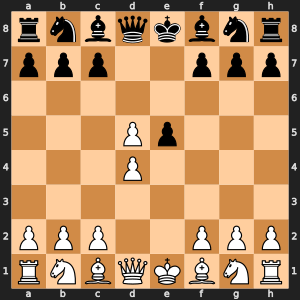

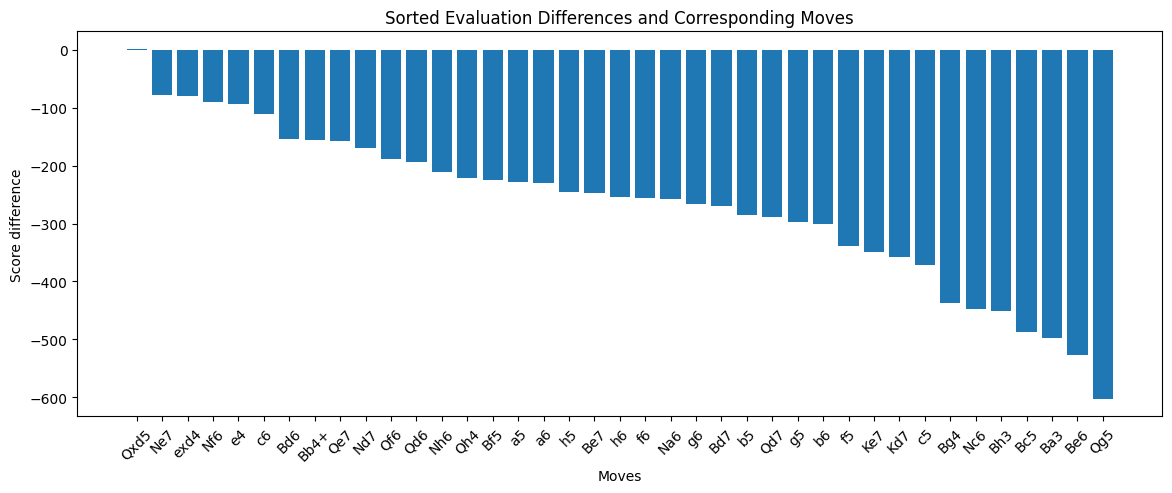


 Worst move: Qg5 score difference: -603
 Best move: Qxd5 score difference: 2
 Mean difference score: -267.1025641025641
            
-----------------------------------------------------------------------------------
 GPT-2 results:
    - Legal moves made: 40 / 200
    - Number of times the worst move was made: 0
    - Number of times the best move was made: 6
    - Number of times an above average move was made: 35
            


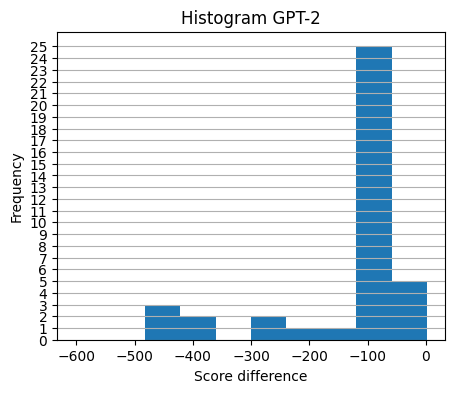

-----------------------------------------------------------------------------------
 Random results:
    - Number of times the worst move was made: 2
    - Number of times the best move was made: 1
    - Number of times an above average move was made: 26
                


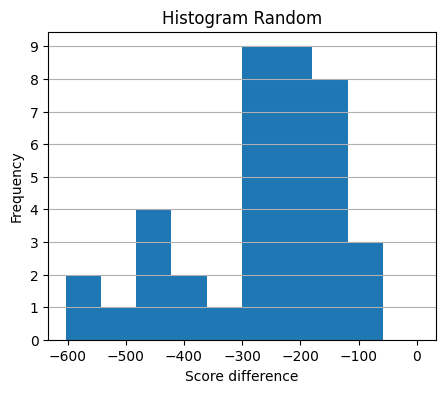

-----------------------------------------------------------------------------------
Player move score difference: -77
Game 1 | Number of moves: 5 | Evaluated answers: 200


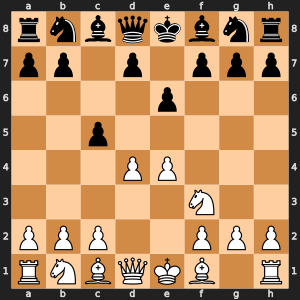

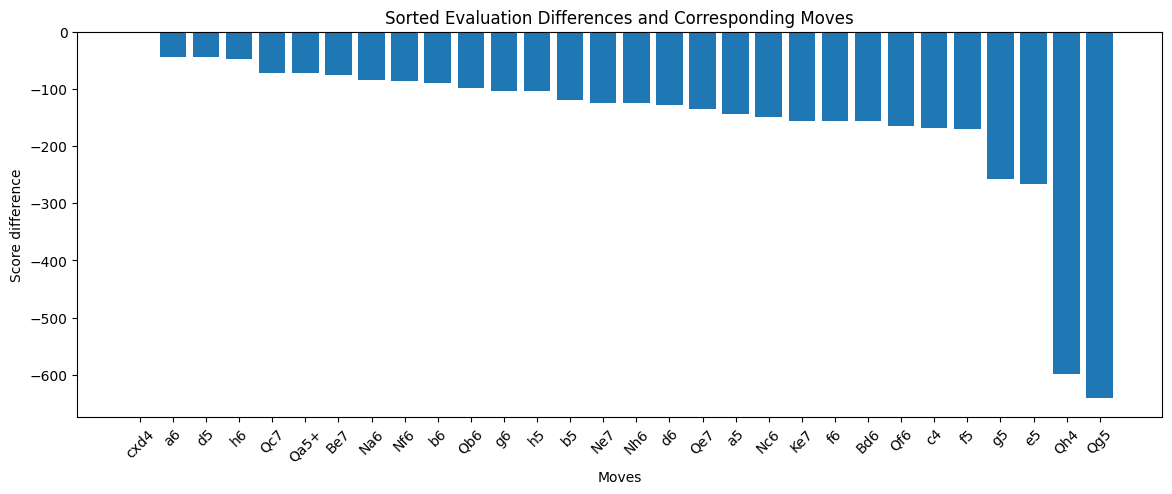


 Worst move: Qg5 score difference: -641
 Best move: cxd4 score difference: -1
 Mean difference score: -152.7
            
-----------------------------------------------------------------------------------
 GPT-2 results:
    - Legal moves made: 162 / 200
    - Number of times the worst move was made: 0
    - Number of times the best move was made: 83
    - Number of times an above average move was made: 151
            


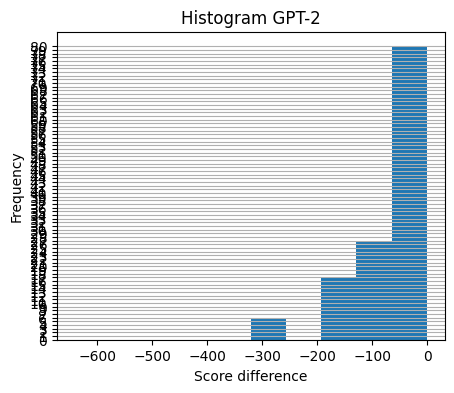

-----------------------------------------------------------------------------------
 Random results:
    - Number of times the worst move was made: 4
    - Number of times the best move was made: 7
    - Number of times an above average move was made: 105
                


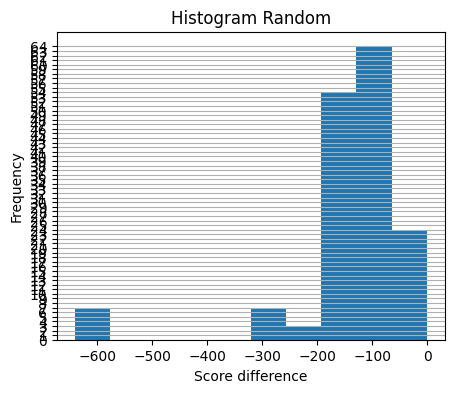

-----------------------------------------------------------------------------------
Player move score difference: -32


In [23]:
num_games = 2
transcripts = test_data_moves["transcript"][:num_games]
summary_gpt, summary_random, summary_player = \
    run_single_game_eval(transcripts, 5, 200, stockfish, generator, tokenizer,
                         print_conclusions=True, show_plots=True)

In [24]:
num_games = 15
transcripts = test_data_moves["transcript"][:num_games]

num_answers = 100
tests_num_moves: List[int] = [5, 10, 15, 20]

player_dict: Dict[str, Any] = {"gpt": None, "random": None, "player": None}
summaries: Dict[int, Dict[str, Any]] = \
    dict((x, deepcopy(player_dict)) for x in tests_num_moves)
player_avg_diff_scores: List[float] = []

for num_moves in tests_num_moves:
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(f"Testing results after {num_moves} moves")
    summary_gpt, summary_random, summary_player = \
        run_single_game_eval(transcripts, num_moves, num_answers,
                             stockfish, generator, tokenizer)
    summaries[num_moves]["gpt"] = summary_gpt
    summaries[num_moves]["random"] = summary_random
    summaries[num_moves]["player"] = summary_player

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Testing results after 5 moves


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Testing results after 10 moves
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Testing results after 15 moves
15 is too many moves for game 1, skipping...
15 is too many moves for game 5, skipping...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Testing results after 20 moves
20 is too many moves for game 1, skipping...
20 is too many moves for game 5, skipping...


Number of moves before evaluation: 5
---------------------------------------
GPT-2:
 - Average score difference after move: -74.15721618957441
 - Total number of legal moves: 887 / 1500
 - Total number of best moves: 120 / 887
 - Total number of worst moves: 0 / 887
 - Total number of above average moves: 810 / 887


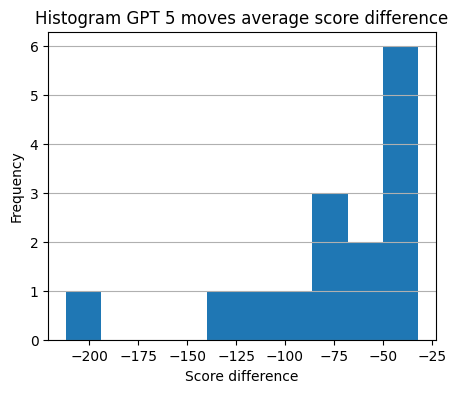

---------------------------------------
Random:
 - Average score difference after move: -159.91107910125461
 - Total number of best moves: 34 / 887
 - Total number of worst moves: 19 / 887
 - Total number of above average moves: 633 / 887


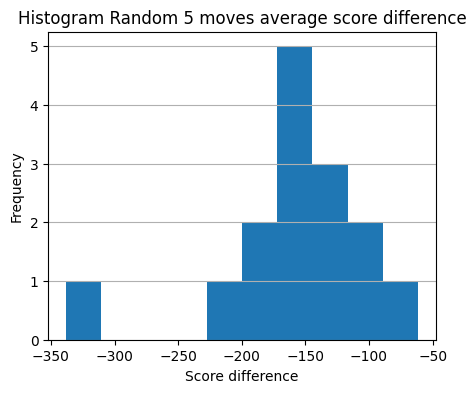

---------------------------------------
Player:
 - Average score difference after move: -31.6
 - Total number of best moves: 4 / 15
 - Total number of worst moves: 0 / 15
 - Total number of above average moves: 15 / 15
Number of moves before evaluation: 10
---------------------------------------
GPT-2:
 - Average score difference after move: -199.52391425636515
 - Total number of legal moves: 725 / 1500
 - Total number of best moves: 66 / 725
 - Total number of worst moves: 7 / 725
 - Total number of above average moves: 550 / 725


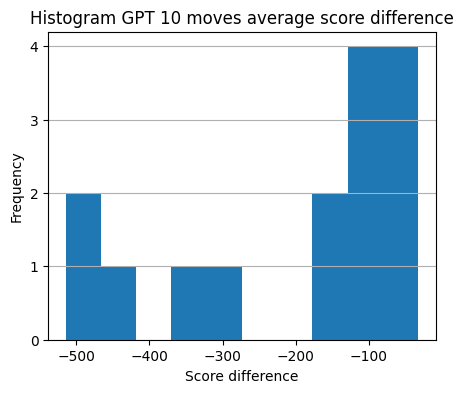

---------------------------------------
Random:
 - Average score difference after move: -269.36998846359995
 - Total number of best moves: 19 / 725
 - Total number of worst moves: 20 / 725
 - Total number of above average moves: 445 / 725


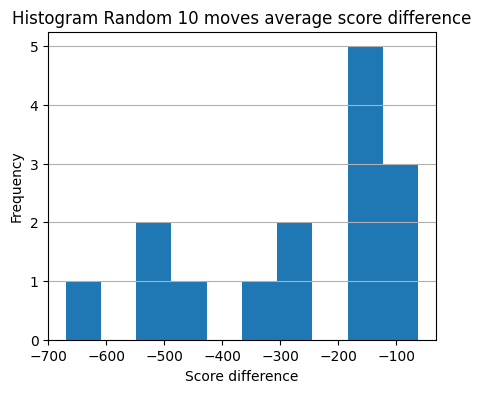

---------------------------------------
Player:
 - Average score difference after move: -46.333333333333336
 - Total number of best moves: 3 / 15
 - Total number of worst moves: 0 / 15
 - Total number of above average moves: 15 / 15
Number of moves before evaluation: 15
---------------------------------------
GPT-2:
 - Average score difference after move: -235.7873161848768
 - Total number of legal moves: 353 / 1300
 - Total number of best moves: 30 / 353
 - Total number of worst moves: 7 / 353
 - Total number of above average moves: 226 / 353


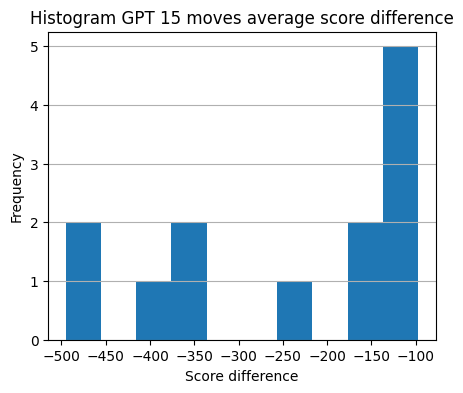

---------------------------------------
Random:
 - Average score difference after move: -278.94455022753834
 - Total number of best moves: 18 / 353
 - Total number of worst moves: 9 / 353
 - Total number of above average moves: 181 / 353


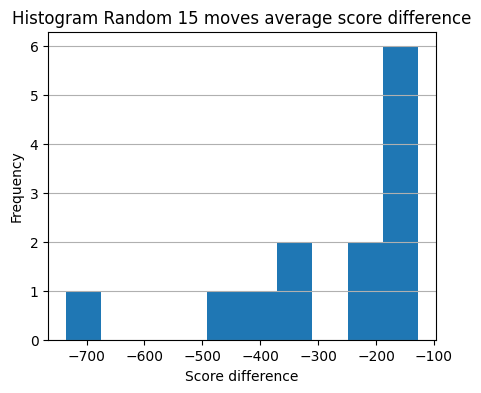

---------------------------------------
Player:
 - Average score difference after move: -84.07692307692308
 - Total number of best moves: 5 / 13
 - Total number of worst moves: 0 / 13
 - Total number of above average moves: 13 / 13
Number of moves before evaluation: 20
---------------------------------------
GPT-2:
 - Average score difference after move: -344.27083373353196
 - Total number of legal moves: 324 / 1300
 - Total number of best moves: 7 / 324
 - Total number of worst moves: 3 / 324
 - Total number of above average moves: 193 / 324


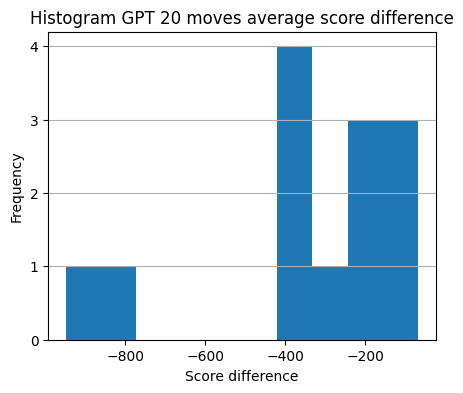

---------------------------------------
Random:
 - Average score difference after move: -368.23267138188714
 - Total number of best moves: 10 / 324
 - Total number of worst moves: 11 / 324
 - Total number of above average moves: 159 / 324


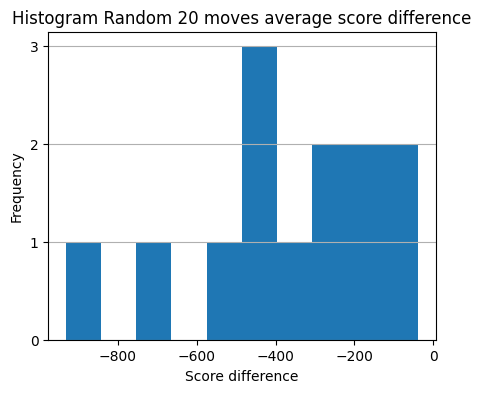

---------------------------------------
Player:
 - Average score difference after move: -105.46153846153847
 - Total number of best moves: 2 / 13
 - Total number of worst moves: 0 / 13
 - Total number of above average moves: 12 / 13

Aggregate results GPT-2
 - Average score difference after move: -213.4348200910871
 - Total number of legal moves: 2289 / 5600
 - Total number of best moves: 223 / 2289
 - Total number of worst moves: 17 / 2289
 - Total number of above average moves: 1779 / 2289
----------------------------------------------------------------
Aggregate results Random
 - Average score difference after move: -269.11457229357
 - Total number of best moves: 81 / 2289
 - Total number of worst moves: 59 / 2289
 - Total number of above average moves: 1418 / 2289
----------------------------------------------------------------
Aggregate results Player
 - Average score difference after move: -66.86794871794872
 - Total number of best moves: 14 / 56
 - Total number of worst moves: 0

In [25]:
show_results_single_eval(summaries, tests_num_moves)

#### Test 2: same tests but try to force legal moves

Issues:
- Every elemnt of a move is treated as separate tokens, random combinations of these tokens at output.
- Since we cannot set ```do_sample=True``` in this scenario (prohibited with forced words), generate one output for more games.

In [26]:
class AlternativesPipeline(TextGenerationPipeline):
    """
    Custom pipeline for generating text with
    forced inclusion of specified words.
    """
    def __init__(self, *args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)

    def __call__(self, *args: Any,
                 force_words: Optional[List[str]] = None,
                 **kwargs: Any) -> Any:
        """
        Override the call method to include forced
        words in the text generation.

        Args:
            force_words (Optional[List[str]]): List of
            words to force include in the generation.

        Returns:
            Any: The generated text with forced words.
        """

        force_words_ids = [
            self.tokenizer(force_words,
                           add_special_tokens=False).input_ids
        ]

        kwargs["force_words_ids"] = force_words_ids
        return super().__call__(*args, **kwargs)

gpt_h = GPT2LMHeadModel.from_pretrained("gpt2-large",
                                        no_repeat_ngram_size=1,
                                        remove_invalid_values=True).to("cuda")

forced_generator = AlternativesPipeline(
    model=gpt_h,
    tokenizer=GPT2Tokenizer.from_pretrained("gpt2-large"),
    device=0
)

model_config = forced_generator.model.config
print(f"""
{model_config.num_beams, model_config.num_beam_groups}
{model_config.do_sample}
{model_config.top_p, model_config.top_k}
{model_config.max_length, model_config.no_repeat_ngram_size}
{model_config.remove_invalid_values}
{model_config.num_return_sequences}
""")


(1, 1, False)
(1.0, 50)
(20, 1, True)
1



In [27]:
alternatives = ["dog"]

print(forced_generator("What is your favorite animal? A:",
                       max_length=25,
                       truncation=True,
                       pad_token_id=forced_generator.tokenizer.eos_token_id,
                       force_words=alternatives,
                       num_return_sequences=1,
                       num_beams=10)[0]["generated_text"])

What is your favorite animal? A: I am a big fan of all animals, but my favorites aredog! It's


In [28]:
num_moves_list = [5, 10, 15, 20]
transcripts = test_data_moves["transcript"][:50]
summaries = run_legal_forced_test(transcripts, num_moves_list,
                                  stockfish, generator, forced_generator)

Tests for 5 moves


 84%|████████▍ | 42/50 [01:58<00:23,  2.95s/it]

5 is too many moves for game 42, skipping...


100%|██████████| 50/50 [02:17<00:00,  2.74s/it]


Tests for 10 moves


 84%|████████▍ | 42/50 [02:07<00:23,  2.91s/it]

10 is too many moves for game 42, skipping...


100%|██████████| 50/50 [02:28<00:00,  2.96s/it]


Tests for 15 moves


  2%|▏         | 1/50 [00:02<02:03,  2.52s/it]

15 is too many moves for game 1, skipping...


 10%|█         | 5/50 [00:10<01:37,  2.17s/it]

15 is too many moves for game 5, skipping...


 42%|████▏     | 21/50 [00:56<01:32,  3.18s/it]

15 is too many moves for game 21, skipping...


 84%|████████▍ | 42/50 [01:55<00:24,  3.08s/it]

15 is too many moves for game 42, skipping...


100%|██████████| 50/50 [02:16<00:00,  2.72s/it]


Tests for 20 moves


  2%|▏         | 1/50 [00:03<02:38,  3.24s/it]

20 is too many moves for game 1, skipping...


 10%|█         | 5/50 [00:12<01:59,  2.65s/it]

20 is too many moves for game 5, skipping...


 42%|████▏     | 21/50 [00:56<01:30,  3.11s/it]

20 is too many moves for game 21, skipping...


 70%|███████   | 35/50 [01:34<00:45,  3.02s/it]

20 is too many moves for game 35, skipping...


 84%|████████▍ | 42/50 [01:53<00:23,  2.97s/it]

20 is too many moves for game 42, skipping...
20 is too many moves for game 43, skipping...


100%|██████████| 50/50 [02:07<00:00,  2.55s/it]


Number of moves before evaluation: 5
---------------------------------------
GPT-2 FORCED ALTERNATIVES:
 - Average score difference after move: -22.235294117647058
 - Total number of legal moves: 17 / 49
 - Total number of best moves: 1 / 17
 - Total number of worst moves: 0 / 17
 - Total number of above average moves: 17 / 17


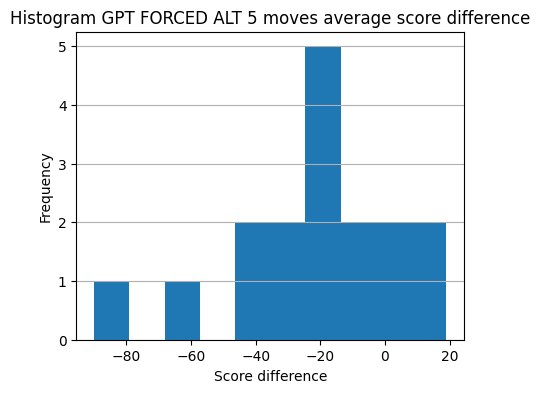

---------------------------------------
GPT-2 NORMAL:
 - Average score difference after move: -60.59375
 - Total number of legal moves: 32 / 49
 - Total number of best moves: 5 / 32
 - Total number of worst moves: 0 / 32
 - Total number of above average moves: 29 / 32


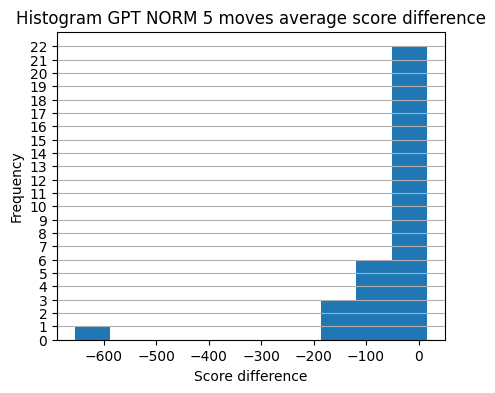

---------------------------------------
Random:
 - Average score difference after move: -96.94117647058823
 - Total number of best moves: 1 / 17
 - Total number of worst moves: 0 / 17
 - Total number of above average moves: 13 / 17


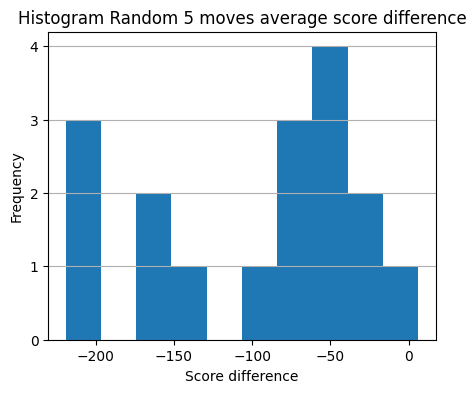

---------------------------------------
Player:
 - Average score difference after move: -27.823529411764707
 - Total number of best moves: 6 / 17
 - Total number of worst moves: 0 / 17
 - Total number of above average moves: 16 / 17


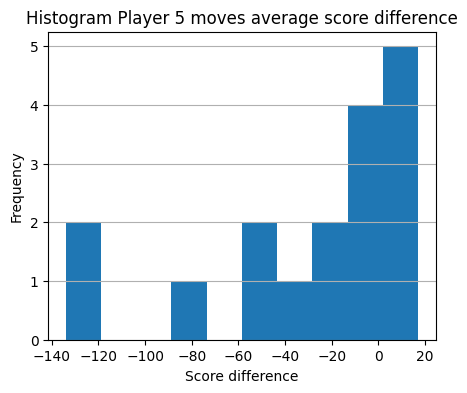

Number of moves before evaluation: 10
---------------------------------------
GPT-2 FORCED ALTERNATIVES:
 - Average score difference after move: -188.0
 - Total number of legal moves: 5 / 49
 - Total number of best moves: 0 / 5
 - Total number of worst moves: 0 / 5
 - Total number of above average moves: 5 / 5


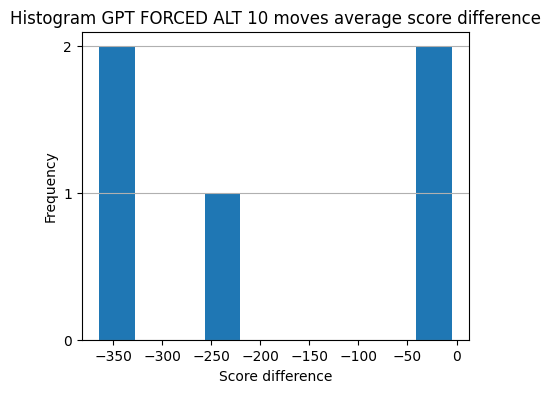

---------------------------------------
GPT-2 NORMAL:
 - Average score difference after move: -144.1818181818182
 - Total number of legal moves: 22 / 49
 - Total number of best moves: 2 / 22
 - Total number of worst moves: 0 / 22
 - Total number of above average moves: 18 / 22


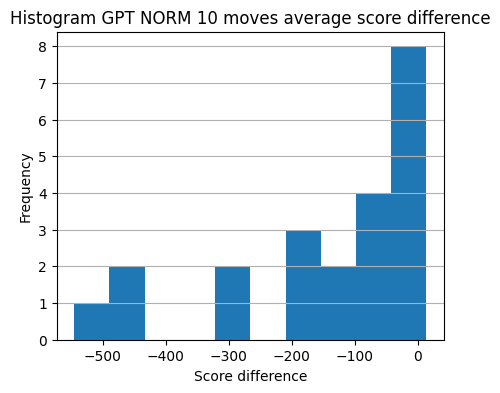

---------------------------------------
Random:
 - Average score difference after move: -228.4
 - Total number of best moves: 0 / 5
 - Total number of worst moves: 0 / 5
 - Total number of above average moves: 3 / 5


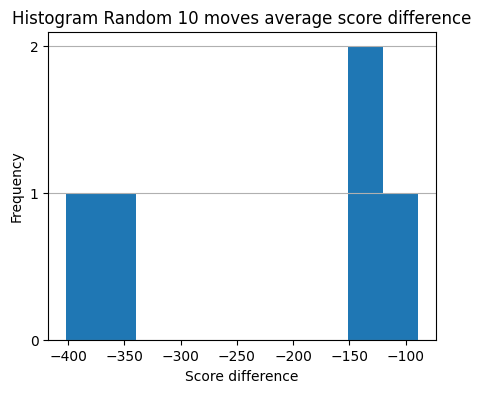

---------------------------------------
Player:
 - Average score difference after move: -7.6
 - Total number of best moves: 1 / 5
 - Total number of worst moves: 0 / 5
 - Total number of above average moves: 5 / 5


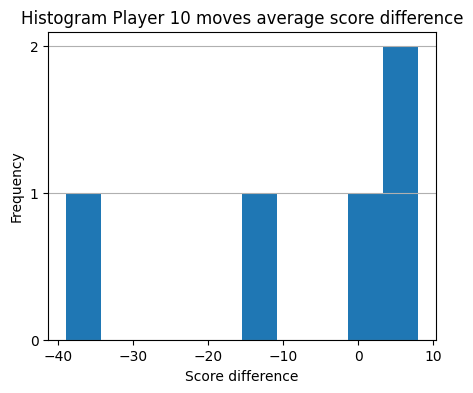

Number of moves before evaluation: 15
---------------------------------------
GPT-2 FORCED ALTERNATIVES:
 - Average score difference after move: -128.64285714285714
 - Total number of legal moves: 14 / 46
 - Total number of best moves: 2 / 14
 - Total number of worst moves: 0 / 14
 - Total number of above average moves: 12 / 14


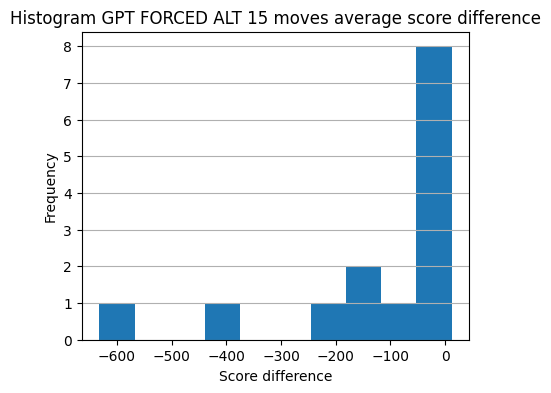

---------------------------------------
GPT-2 NORMAL:
 - Average score difference after move: -137.66666666666666
 - Total number of legal moves: 12 / 46
 - Total number of best moves: 1 / 12
 - Total number of worst moves: 0 / 12
 - Total number of above average moves: 10 / 12


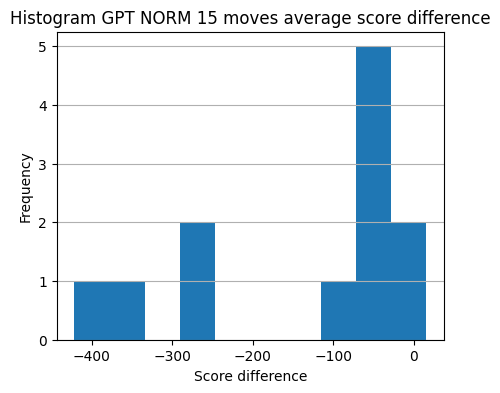

---------------------------------------
Random:
 - Average score difference after move: -310.92857142857144
 - Total number of best moves: 1 / 14
 - Total number of worst moves: 1 / 14
 - Total number of above average moves: 7 / 14


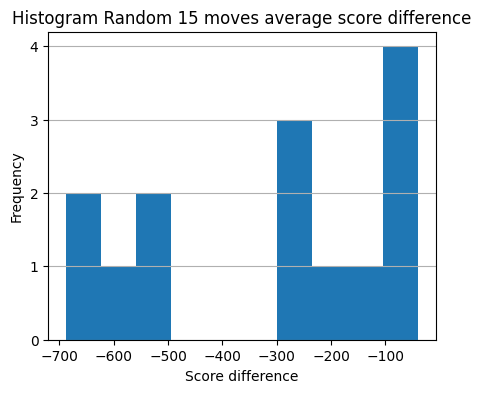

---------------------------------------
Player:
 - Average score difference after move: -61.285714285714285
 - Total number of best moves: 3 / 14
 - Total number of worst moves: 0 / 14
 - Total number of above average moves: 14 / 14


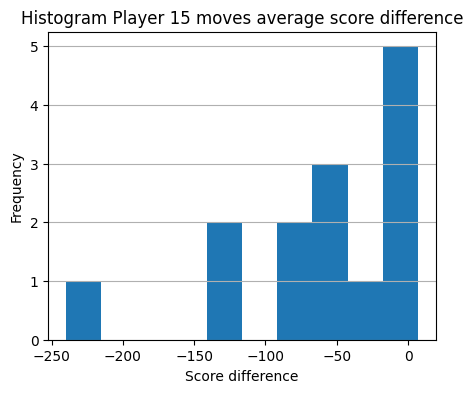

Number of moves before evaluation: 20
---------------------------------------
GPT-2 FORCED ALTERNATIVES:
 - Average score difference after move: -163.25
 - Total number of legal moves: 4 / 44
 - Total number of best moves: 0 / 4
 - Total number of worst moves: 0 / 4
 - Total number of above average moves: 3 / 4


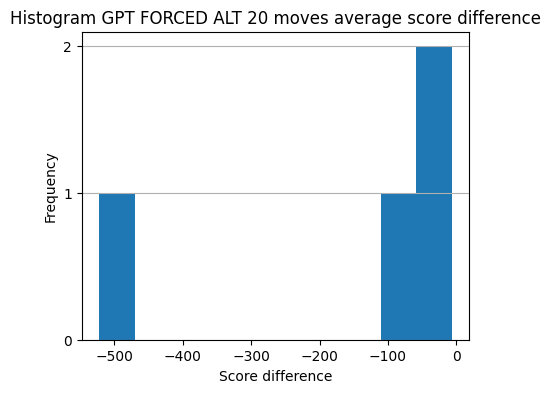

---------------------------------------
GPT-2 NORMAL:
 - Average score difference after move: -199.3
 - Total number of legal moves: 10 / 44
 - Total number of best moves: 0 / 10
 - Total number of worst moves: 1 / 10
 - Total number of above average moves: 7 / 10


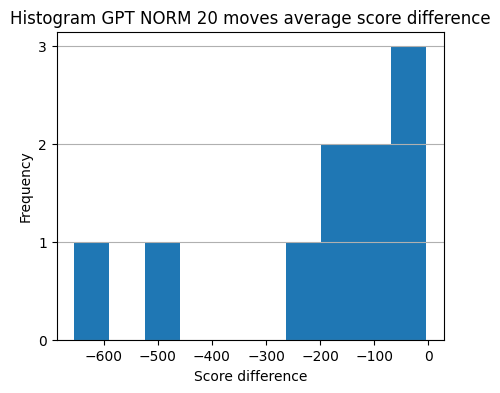

---------------------------------------
Random:
 - Average score difference after move: -89.0
 - Total number of best moves: 0 / 4
 - Total number of worst moves: 0 / 4
 - Total number of above average moves: 3 / 4


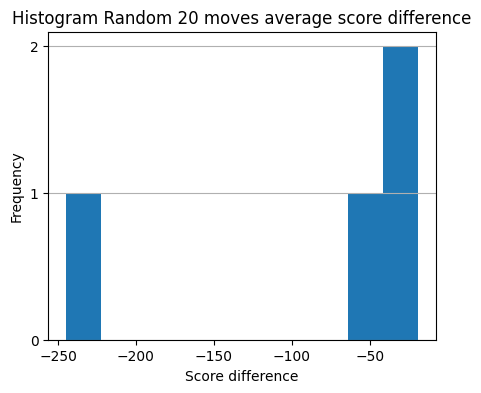

---------------------------------------
Player:
 - Average score difference after move: -48.75
 - Total number of best moves: 0 / 4
 - Total number of worst moves: 0 / 4
 - Total number of above average moves: 4 / 4


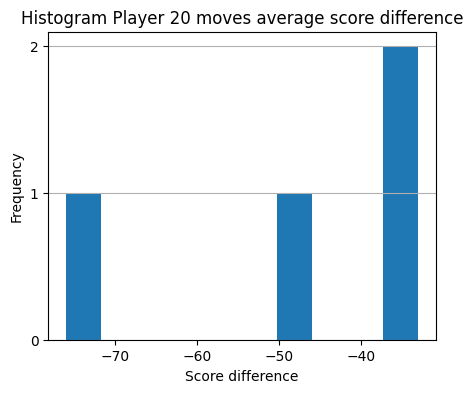

Aggregate results GPT-2 FORCED ALTERNATIVES
 - Average score difference after move: -125.532
 - Total number of legal moves: 40 / 188
 - Total number of best moves: 3 / 40
 - Total number of worst moves: 0 / 40
 - Total number of above average moves: 37 / 40
----------------------------------------------------------------
Aggregate results GPT-2 NORMAL
 - Average score difference after move: -135.436
 - Total number of legal moves: 76 / 188
 - Total number of best moves: 8 / 76
 - Total number of worst moves: 1 / 76
 - Total number of above average moves: 64 / 76
----------------------------------------------------------------
Aggregate results Random
 - Average score difference after move: -181.317
 - Total number of best moves: 2 / 40
 - Total number of worst moves: 1 / 40
 - Total number of above average moves: 26 / 40
----------------------------------------------------------------
Aggregate results Player
 - Average score difference after move: -36.365
 - Total number of best move

In [29]:
show_results_forced_test(summaries, num_moves_list)